In [1]:
from modules import *
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm
import cartopy.crs as ccrs
from matplotlib import cm
import matplotlib as mpl


import statsmodels.api as sm

In [2]:
seaice = w3.load_data(['seaice'],projection='SouthPolarStereo', temporal_resolution='annual',temporal_decomposition='raw',detrend='raw').seaice
seaice = seaice.where(seaice>0.15, seaice, 0)
area = xr.open_dataset('data/area_files/processed_nsidc.nc').area

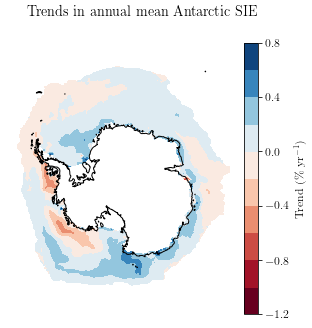

In [3]:
mpl.style.use('stylesheets/contour.mplstyle')
fig = plt.figure(figsize=(5,5))
dependant_trend = seaice.sortby('time').polyfit(dim='time', deg=1) * 1e9*60*60*24*365.25 * 100
seaice_m = dependant_trend['polyfit_coefficients'].sel(degree=1)
seaice_m = seaice_m.where(abs(seaice_m) >=0.0001)
max_ = seaice_m.max()
min_ = seaice_m.min() 
divnorm = TwoSlopeNorm(vmin=min_, vcenter=0, vmax=max_)
levels = np.linspace(min_,max_,10)
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
# Plotting
contor = ax.contourf(seaice_m.x, seaice_m.y, seaice_m.transpose(), cmap = 'RdBu', levels = 11, norm = divnorm, transform=ccrs.SouthPolarStereo())
ax.coastlines()
ax.set_axis_off()
cbar = plt.colorbar(contor)
cbar.set_label('Trend (\% yr$^{-1}$)')
fig.suptitle(f'Trends in annual mean Antarctic SIE')
plt.savefig('seaice_trends.pdf')
plt.show()

In [4]:
def sci_notation(number, sig_fig=2):
    ret_string = "{0:.{1:d}e}".format(number, sig_fig)
    a, b = ret_string.split("e")
    # remove leading "+" and strip leading zeros
    b = int(b)
    return "$" +a + " \\times 10^" + str(b)+ "$"

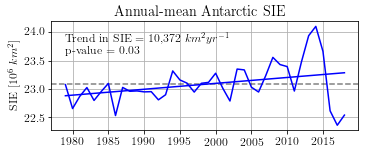

In [7]:
mpl.style.use('stylesheets/timeseries.mplstyle')
fig = plt.figure()
seaice_m = (seaice*area).sortby('time').sum(dim=('x','y'))
seaice_m = seaice_m.loc[seaice_m !=np.nan]
seaice_m = seaice_m.loc[seaice_m !=0]

X2 = sm.add_constant(seaice_m.time.astype(np.float64).values/(1e9*60*60*24*365.25))
est = sm.OLS(seaice_m.values, X2)
est2 = est.fit()
b, m = est2.params
seaice_trend = seaice_m.time.astype(np.float64)/(1e9*60*60*24*365.25) * m + b

ax = fig.add_subplot(111)
# Plotting
ax.axhline(seaice_trend.mean()/1e6, color = 'black', ls = '--', alpha = 0.5)
ax.plot(seaice_m.time, seaice_m/1e6, color='blue')
ax.plot(seaice_m.time, seaice_trend/1e6, color='blue')
min_ = (min(seaice.time).values)
ax.text(min_,seaice_trend.mean()/1e6 + 1.5*(seaice_m).std()/1e6, f'Trend in SIE = {m:,.0f}'+f' $km^2 yr^{{-1}}$\np-value = {est2.pvalues[1]:.2f}')
ax.set_ylabel('SIE [$10^{6}\ km^{2}$]')
fig.suptitle(f'Annual-mean Antarctic SIE')
plt.xticks()
plt.savefig('seaice_timeseries.pdf')
plt.grid()
plt.savefig('seaice_timeseries_with_grid.pdf')
plt.show()